# Análise preditiva do Programa Mais Médicos

## 1. Análise preditiva para desfecho categórico (churn)

In [1]:
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
import optuna




### Carregamento dos dados

In [142]:
df_completo = pd.read_csv(r"C:\Users\Lapei_Cigets\Documents\GitHub\sa_maismedicos\01_dados\dados resultantes\df_modelagem0303.csv")

list(df_completo.columns)

['Unnamed: 0',
 'meses_no_local_alocado',
 'churn',
 'idade',
 'anos_formacao',
 'atuacao_previa_no_municipio',
 'anos_atuacao_previa_no_municipio',
 'media_vinculos_mes',
 'Prorrogado',
 'm_agente_saude',
 'm_tec_aux_enf',
 'm_enfermeiro',
 'm_dentista',
 'regiao_destino',
 'populacao',
 'porte',
 'pib_percapita',
 'variacao_pib',
 'tx_pop_ocupada_2019',
 'orcamento_saude',
 'esgotamento_sanitario',
 'taxa_homicidio',
 'ideb_anosfinais',
 'investimento_infraestrutura',
 'equipamentos_esportivos',
 'equipamentos_culturais',
 'distancia_capital']

In [143]:
df_completo = df_completo.drop(["Unnamed: 0",
              "meses_no_local_alocado",
              "variacao_pib",
              'm_dentista'], 
             axis='columns')

df_completo[['m_agente_saude', 'm_tec_aux_enf', 'm_enfermeiro']] = df_completo[['m_agente_saude', 'm_tec_aux_enf', 
                                                                                     'm_enfermeiro']].fillna(0)
df_completo['churn'] = df_completo['churn'].map({'permanece': 0, 'migrou': 1})

df_m1 = df_completo[['churn', 'idade', 'anos_formacao', 'atuacao_previa_no_municipio' ,'anos_atuacao_previa_no_municipio',
                   'regiao_destino']]

df_m2 = df_completo[['churn', 'idade', 'anos_formacao', 'atuacao_previa_no_municipio' ,'anos_atuacao_previa_no_municipio',
                   'media_vinculos_mes', 'm_agente_saude', 'm_tec_aux_enf', 'm_enfermeiro']]

df_m3 = df_completo.drop(['Prorrogado'], axis='columns')

df_m4 = df_completo

In [13]:
df_m2.columns

Index(['churn', 'idade', 'anos_formacao', 'atuacao_previa_no_municipio',
       'anos_atuacao_previa_no_municipio', 'media_vinculos_mes',
       'm_agente_saude', 'm_tec_aux_enf', 'm_enfermeiro'],
      dtype='object')

### Pré-processamento e divisão em treino e teste

In [101]:
def dividir_e_balancear(df):
    y = df['churn']  
    X = df.drop(columns=['churn']) 

    num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
    ])

    preprocessor = ColumnTransformer([
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ])
    
    # Divisão dos dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Aplicar o pré-processamento
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # Aplicação do SMOTE para balanceamento
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    y_train = y_train.astype(int)  # Garantir que y_train seja numérico
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)
    
    return X_train_resampled, X_test_processed, y_train_resampled, y_test, preprocessor, X_train

In [151]:
X_train_m1, X_test_m1, y_train_m1, y_test_m1, preprocessor_m1, X_train_raw1 = dividir_e_balancear(df_m1)
X_train_m2, X_test_m2, y_train_m2, y_test_m2, preprocessor_m2, X_train_raw2 = dividir_e_balancear(df_m2)
X_train_m3, X_test_m3, y_train_m3, y_test_m3, preprocessor_m3, X_train_raw3 = dividir_e_balancear(df_m3)
X_train_m4, X_test_m4, y_train_m4, y_test_m4, preprocessor_m4, X_train_raw4 = dividir_e_balancear(df_m4)

In [16]:
X_train_m3

array([[-0.49066246,  0.30071024, -0.23602953, ...,  0.        ,
         0.        ,  0.        ],
       [-0.59424307,  0.04222042, -0.23602953, ...,  0.        ,
         0.        ,  1.        ],
       [-0.90498492, -0.54633579, -0.23602953, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.09782014, -0.40223117, -0.23602953, ...,  1.        ,
         0.        ,  0.        ],
       [-0.66500437, -0.49285479, -0.23602953, ...,  1.        ,
         0.        ,  0.        ],
       [-0.40964269,  0.1646376 ,  0.46933951, ...,  0.        ,
         0.        ,  0.        ]])

## Instanciando modelos e rodando modelos

No bloco de código abaixo é definida a função para treinar e avaliar os modelos sem Optuna.

In [103]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier()
}

param_grids = {
    'Logistic Regression': {'classifier__C': [0.01, 0.1, 1, 10]},
    'Decision Tree': {'classifier__max_depth': [3, 5, 10]},
    'Random Forest': {
        'classifier__n_estimators': [100, 300, 500],
        'classifier__max_depth': [3, 5, 10],
        'classifier__min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'classifier__n_estimators': [100, 300, 500],
        'classifier__max_depth': [3, 6, 9],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__subsample': [0.7, 0.85, 1.0],
        'classifier__colsample_bytree': [0.7, 0.85, 1.0],
        'classifier__gamma': [0, 0.1, 0.5]
    },
    'LightGBM': {
        'classifier__n_estimators': [100, 300, 500],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__num_leaves': [20, 31, 40],
        'classifier__min_child_samples': [10, 20, 30]
    }
}


def treinando_avaliando(x_train, y_train, x_test, y_test):
    # Validação cruzada e otimização de hiperparâmetros
    best_models = {}

    for name, model in models.items():
        print(f"Treinando modelo: {name}")
        pipeline = Pipeline([('classifier', model)])

        param_grid = param_grids.get(name, {})
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(x_train, y_train)

        best_models[name] = grid_search.best_estimator_
        print(f"Melhores parâmetros para {name}: {grid_search.best_params_}\n")

    # Avaliação final no conjunto de teste
    results = []
    for name, model in best_models.items():
        y_pred = model.predict(x_test)
        y_prob = model.predict_proba(x_test)[:, 1]
        results.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_prob)
        })
    
    return results, models

No bloco de código abaixo é definida a função para treinar e avaliar os modelos com Optuna.

In [104]:
# Definir uma função objetivo para o Optuna
def objective(trial, model_name, x_train, y_train):
    # Definir os hiperparâmetros a serem otimizados para cada modelo
    if model_name == 'Logistic Regression':
        C = trial.suggest_loguniform('C', 0.01, 10)
        model = LogisticRegression(C=C)
    
    elif model_name == 'Decision Tree':
        max_depth = trial.suggest_int('max_depth', 3, 10)
        model = DecisionTreeClassifier(max_depth=max_depth)
    
    elif model_name == 'Random Forest':
        n_estimators = trial.suggest_int('n_estimators', 100, 500, step=100)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
    
    elif model_name == 'XGBoost':
        n_estimators = trial.suggest_int('n_estimators', 100, 500, step=100)
        max_depth = trial.suggest_int('max_depth', 3, 9)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
        subsample = trial.suggest_float('subsample', 0.7, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.7, 1.0)
        gamma = trial.suggest_float('gamma', 0, 0.5)
        model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, subsample=subsample, colsample_bytree=colsample_bytree, gamma=gamma, use_label_encoder=False, eval_metric='logloss')
    
    elif model_name == 'LightGBM':
        n_estimators = trial.suggest_int('n_estimators', 100, 500, step=100)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
        num_leaves = trial.suggest_int('num_leaves', 20, 40)
        min_child_samples = trial.suggest_int('min_child_samples', 10, 30)
        model = lgb.LGBMClassifier(n_estimators=n_estimators, learning_rate=learning_rate, num_leaves=num_leaves, min_child_samples=min_child_samples)
    
    # Treinamento do modelo
    model.fit(x_train, y_train)
    
    # Obter a probabilidade da classe positiva (para calcular o ROC AUC)
    y_prob = model.predict_proba(x_train)[:, 1]
    
    # Calcular o ROC AUC para esta combinação de hiperparâmetros
    roc_auc = roc_auc_score(y_train, y_prob)
    
    # Retornar tanto o modelo quanto o ROC AUC
    return model, roc_auc

def treinando_avaliando_optuna(x_train, y_train, x_test, y_test):
    best_models = {}
    best_roc_auc = {}

    for name in models.keys():
        print(f"Treinando modelo com Optuna: {name}")

        # Otimização de hiperparâmetros com Optuna
        study = optuna.create_study(direction="maximize")  # Maximizar o ROC AUC
        study.optimize(lambda trial: objective(trial, name, x_train, y_train)[1], n_trials=10)  # Aqui estamos otimizar apenas o ROC AUC

        # Obter o melhor modelo do estudo
        best_model, best_roc = objective(study.best_trial, name, x_train, y_train)
        best_models[name] = best_model
        best_roc_auc[name] = best_roc
        
        print(f"Melhores parâmetros para {name}: {study.best_params}\n")

    # Avaliação final no conjunto de teste
    results = []
    for name, model in best_models.items():
        y_pred = model.predict(x_test)
        y_prob = model.predict_proba(x_test)[:, 1]
        results.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_prob)
        })
    
    return results, models

### Modelo 1

In [76]:
results_m1, models_m1 = treinando_avaliando_optuna(X_train_m1, y_train_m1, X_test_m1, y_test_m1)
results_m1_df = pd.DataFrame(results_m1)
print(results_m1_df.sort_values(by='ROC AUC', ascending=False))

[I 2025-03-03 19:28:43,437] A new study created in memory with name: no-name-b562bcbd-2aa3-4722-b146-03eadb117207
C:\Users\Lapei_Cigets\AppData\Local\Temp\ipykernel_26296\4280298713.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.01, 10)
[I 2025-03-03 19:28:43,455] Trial 0 finished with value: 0.703808864265928 and parameters: {'C': 0.06628613697598781}. Best is trial 0 with value: 0.703808864265928.
C:\Users\Lapei_Cigets\AppData\Local\Temp\ipykernel_26296\4280298713.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.01, 10)
[I 2025-03-03 19:28:43,464] Trial 1 finished with value: 0.70393178670

Treinando modelo com Optuna: Logistic Regression
Melhores parâmetros para Logistic Regression: {'C': 0.16123954250120562}

Treinando modelo com Optuna: Decision Tree


[I 2025-03-03 19:28:43,620] Trial 4 finished with value: 0.7083388157894737 and parameters: {'max_depth': 3}. Best is trial 0 with value: 0.8859972299168974.
[I 2025-03-03 19:28:43,629] Trial 5 finished with value: 0.8598104224376731 and parameters: {'max_depth': 8}. Best is trial 0 with value: 0.8859972299168974.
[I 2025-03-03 19:28:43,639] Trial 6 finished with value: 0.8598104224376731 and parameters: {'max_depth': 8}. Best is trial 0 with value: 0.8859972299168974.
[I 2025-03-03 19:28:43,649] Trial 7 finished with value: 0.7748052285318558 and parameters: {'max_depth': 5}. Best is trial 0 with value: 0.8859972299168974.
[I 2025-03-03 19:28:43,657] Trial 8 finished with value: 0.8598104224376731 and parameters: {'max_depth': 8}. Best is trial 0 with value: 0.8859972299168974.
[I 2025-03-03 19:28:43,667] Trial 9 finished with value: 0.9119035664819944 and parameters: {'max_depth': 10}. Best is trial 9 with value: 0.9119035664819944.
[I 2025-03-03 19:28:43,710] A new study created in 

Melhores parâmetros para Decision Tree: {'max_depth': 10}

Treinando modelo com Optuna: Random Forest


[I 2025-03-03 19:28:44,056] Trial 0 finished with value: 0.7958968144044322 and parameters: {'n_estimators': 200, 'max_depth': 6, 'min_samples_split': 7}. Best is trial 0 with value: 0.7958968144044322.
[I 2025-03-03 19:28:44,495] Trial 1 finished with value: 0.7313538781163436 and parameters: {'n_estimators': 300, 'max_depth': 3, 'min_samples_split': 6}. Best is trial 0 with value: 0.7958968144044322.
[I 2025-03-03 19:28:45,065] Trial 2 finished with value: 0.8912707756232686 and parameters: {'n_estimators': 400, 'max_depth': 9, 'min_samples_split': 3}. Best is trial 2 with value: 0.8912707756232686.
[I 2025-03-03 19:28:45,517] Trial 3 finished with value: 0.7704570637119112 and parameters: {'n_estimators': 400, 'max_depth': 5, 'min_samples_split': 9}. Best is trial 2 with value: 0.8912707756232686.
[I 2025-03-03 19:28:45,954] Trial 4 finished with value: 0.7696208448753463 and parameters: {'n_estimators': 400, 'max_depth': 5, 'min_samples_split': 8}. Best is trial 2 with value: 0.891

Melhores parâmetros para Random Forest: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 6}

Treinando modelo com Optuna: XGBoost


c:\Users\Lapei_Cigets\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:28:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-03-03 19:28:47,983] Trial 1 finished with value: 0.9187162396121884 and parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.05158840345400247, 'subsample': 0.8874209257272787, 'colsample_bytree': 0.7930505684046774, 'gamma': 0.4063535483383772}. Best is trial 0 with value: 0.9352060249307479.
c:\Users\Lapei_Cigets\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:28:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-03-03 19:28:48,095] T

Melhores parâmetros para XGBoost: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.09677783077883655, 'subsample': 0.8068164901080231, 'colsample_bytree': 0.8691430416265242, 'gamma': 0.3414876658317031}

Treinando modelo com Optuna: LightGBM
[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 428
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-03-03 19:28:50,217] Trial 1 finished with value: 0.9347870498614959 and parameters: {'n_estimators': 400, 'learning_rate': 0.04185716923915179, 'num_leaves': 29, 'min_child_samples': 20}. Best is trial 0 with value: 0.9700311634349031.


[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 428
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 428
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-03-03 19:28:50,316] Trial 2 finished with value: 0.9349047783933518 and parameters: {'n_estimators': 200, 'learning_rate': 0.08893862256005934, 'num_leaves': 29, 'min_child_samples': 23}. Best is trial 0 with value: 0.9700311634349031.


[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 428
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-03-03 19:28:50,655] Trial 3 finished with value: 0.9063218490304709 and parameters: {'n_estimators': 500, 'learning_rate': 0.010648633090844807, 'num_leaves': 40, 'min_child_samples': 16}. Best is trial 0 with value: 0.9700311634349031.
[I 2025-03-03 19:28:50,708] Trial 4 finished with value: 0.8347602146814405 and parameters: {'n_estimators': 100, 'learning_rate': 0.013034359486804597, 'num_leaves': 28, 'min_child_samples': 10}. Best is trial 0 with value: 0.9700311634349031.
[I 2025-03-03 19:28:50,837] Trial 5 finished with value: 0.9444122229916897 and parameters: {'n_estimators': 400, 'learning_rate': 0.06799618718744675, 'num_leaves': 21, 'min_child_samples': 14}. Best is trial 0 with value: 0.9700311634349031.


[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 428
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 428
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 760, number of negative: 760
[Ligh

[I 2025-03-03 19:28:51,041] Trial 6 finished with value: 0.952306959833795 and parameters: {'n_estimators': 400, 'learning_rate': 0.06040379534833971, 'num_leaves': 32, 'min_child_samples': 25}. Best is trial 0 with value: 0.9700311634349031.


[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 428
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-03-03 19:28:51,260] Trial 7 finished with value: 0.8782626385041552 and parameters: {'n_estimators': 500, 'learning_rate': 0.011051253123029297, 'num_leaves': 24, 'min_child_samples': 16}. Best is trial 0 with value: 0.9700311634349031.
[I 2025-03-03 19:28:51,378] Trial 8 finished with value: 0.9191334833795015 and parameters: {'n_estimators': 300, 'learning_rate': 0.040169462256230797, 'num_leaves': 21, 'min_child_samples': 11}. Best is trial 0 with value: 0.9700311634349031.


[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 428
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 428
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-03-03 19:28:51,647] Trial 9 finished with value: 0.944419148199446 and parameters: {'n_estimators': 400, 'learning_rate': 0.06300270581098949, 'num_leaves': 29, 'min_child_samples': 30}. Best is trial 0 with value: 0.9700311634349031.


[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 428
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Melhores parâmetros para LightGBM: {'n_estimators': 500, 'learning_rate': 0.07651344511721817, 'num_leaves': 28, 'min_child_samples': 14}

                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.667732   0.726316  0.726316  0.726316  0.697540
2        Random Forest  0.661342   0.735955  0.689474  0.711957  0.685772
3              XGBoost  0.613419   0.688525  0.663158  0.675603  0.609649
4             LightGBM  0.613419   0.680628  0.684211  0.682415  0.580552
1        Decision Tree  0.578275   0.649485  0.663158  0.65

In [20]:
best_model_name = results_m1_df.sort_values(by='ROC AUC', ascending=False).iloc[0]['Model']
best_model_m1 = models_m1[best_model_name]

In [21]:
# Treinando o modelo
best_model_m1.fit(X_train_m1, y_train_m1)

# Fazendo previsões no conjunto de teste
y_pred = best_model_m1.predict(X_test_m1)

# Imprimindo o relatório de classificação
print(classification_report(y_test_m1, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.57      0.57       123
           1       0.72      0.73      0.72       190

    accuracy                           0.66       313
   macro avg       0.65      0.65      0.65       313
weighted avg       0.66      0.66      0.66       313



In [22]:
import shap

shap.initjs() #habilitando a visualização dos gráficos

In [ ]:
explainer = shap.KernelExplainer(best_model_m1.predict, 
                           X_test_m1)

shap_values = explainer(X_test_m1)

In [ ]:
shap.summary_plot(shap_values, features= X_train_m1, 
                  feature_names= df_m1.columns, 
                  plot_type="bar")

### Modelo 2

In [105]:
results_m2, models_m2 = treinando_avaliando_optuna(X_train_m2, y_train_m2, X_test_m2, y_test_m2)
results_m2_df = pd.DataFrame(results_m2)
print(results_m2_df.sort_values(by='ROC AUC', ascending=False))

[I 2025-03-03 20:01:36,511] A new study created in memory with name: no-name-77e235ed-eab7-401e-8178-1b1f789d7409
C:\Users\Lapei_Cigets\AppData\Local\Temp\ipykernel_26296\4280298713.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.01, 10)
[I 2025-03-03 20:01:36,522] Trial 0 finished with value: 0.7229536011080333 and parameters: {'C': 0.2248997358926773}. Best is trial 0 with value: 0.7229536011080333.
C:\Users\Lapei_Cigets\AppData\Local\Temp\ipykernel_26296\4280298713.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.01, 10)
[I 2025-03-03 20:01:36,531] Trial 1 finished with value: 0.7228254847

Treinando modelo com Optuna: Logistic Regression
Melhores parâmetros para Logistic Regression: {'C': 0.2248997358926773}

Treinando modelo com Optuna: Decision Tree


[I 2025-03-03 20:01:36,710] Trial 7 finished with value: 0.8582245498614959 and parameters: {'max_depth': 6}. Best is trial 2 with value: 0.8939006232686979.
[I 2025-03-03 20:01:36,725] Trial 8 finished with value: 0.8939006232686979 and parameters: {'max_depth': 7}. Best is trial 2 with value: 0.8939006232686979.
[I 2025-03-03 20:01:36,742] Trial 9 finished with value: 0.8582539819944599 and parameters: {'max_depth': 6}. Best is trial 2 with value: 0.8939006232686979.
[I 2025-03-03 20:01:36,753] A new study created in memory with name: no-name-fe67cc8a-616a-4967-ac9b-bbbcc62bbf21


Melhores parâmetros para Decision Tree: {'max_depth': 7}

Treinando modelo com Optuna: Random Forest


[I 2025-03-03 20:01:37,829] Trial 0 finished with value: 0.9023476454293629 and parameters: {'n_estimators': 500, 'max_depth': 7, 'min_samples_split': 10}. Best is trial 0 with value: 0.9023476454293629.
[I 2025-03-03 20:01:38,495] Trial 1 finished with value: 0.90211391966759 and parameters: {'n_estimators': 300, 'max_depth': 7, 'min_samples_split': 10}. Best is trial 0 with value: 0.9023476454293629.
[I 2025-03-03 20:01:39,421] Trial 2 finished with value: 0.9279033933518006 and parameters: {'n_estimators': 500, 'max_depth': 8, 'min_samples_split': 10}. Best is trial 2 with value: 0.9279033933518006.
[I 2025-03-03 20:01:39,990] Trial 3 finished with value: 0.8479207063711911 and parameters: {'n_estimators': 400, 'max_depth': 5, 'min_samples_split': 2}. Best is trial 2 with value: 0.9279033933518006.
[I 2025-03-03 20:01:40,106] Trial 4 finished with value: 0.7951480263157894 and parameters: {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 5}. Best is trial 2 with value: 0.92

Melhores parâmetros para Random Forest: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 10}

Treinando modelo com Optuna: XGBoost


c:\Users\Lapei_Cigets\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:01:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-03-03 20:01:43,683] Trial 0 finished with value: 0.9979345567867036 and parameters: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.02432940512339447, 'subsample': 0.7573435582095529, 'colsample_bytree': 0.94912187534491, 'gamma': 0.014607242931538034}. Best is trial 0 with value: 0.9979345567867036.
c:\Users\Lapei_Cigets\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:01:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-03-03 20:01:43,995] T

Melhores parâmetros para XGBoost: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.09552334941844556, 'subsample': 0.8556749514716566, 'colsample_bytree': 0.9152395645154505, 'gamma': 0.2439682344215129}

Treinando modelo com Optuna: LightGBM
[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total

[I 2025-03-03 20:01:45,349] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.04298038773745646, 'num_leaves': 39, 'min_child_samples': 27}. Best is trial 2 with value: 1.0.
[I 2025-03-03 20:01:45,470] Trial 3 finished with value: 0.9998701523545707 and parameters: {'n_estimators': 300, 'learning_rate': 0.05606110178128346, 'num_leaves': 31, 'min_child_samples': 20}. Best is trial 2 with value: 1.0.


[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-03-03 20:01:45,789] Trial 4 finished with value: 0.9994806094182824 and parameters: {'n_estimators': 500, 'learning_rate': 0.01901186032845168, 'num_leaves': 37, 'min_child_samples': 10}. Best is trial 2 with value: 1.0.
[I 2025-03-03 20:01:45,960] Trial 5 finished with value: 0.9724913434903047 and parameters: {'n_estimators': 500, 'learning_rate': 0.01235410948208778, 'num_leaves': 23, 'min_child_samples': 21}. Best is trial 2 with value: 1.0.


[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-03-03 20:01:46,058] Trial 6 finished with value: 0.9551713988919668 and parameters: {'n_estimators': 300, 'learning_rate': 0.016074595217934307, 'num_leaves': 22, 'min_child_samples': 22}. Best is trial 2 with value: 1.0.
[I 2025-03-03 20:01:46,215] Trial 7 finished with value: 0.9986063019390582 and parameters: {'n_estimators': 400, 'learning_rate': 0.03314119850114749, 'num_leaves': 27, 'min_child_samples': 25}. Best is trial 2 with value: 1.0.
[I 2025-03-03 20:01:46,257] Trial 8 finished with value: 0.985957409972299 and parameters: {'n_estimators': 100, 'learning_rate': 0.07617503883915101, 'num_leaves': 22, 'min_child_samples': 15}. Best is trial 2 with value: 1.0.


[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-03-03 20:01:46,447] Trial 9 finished with value: 0.9991845567867036 and parameters: {'n_estimators': 500, 'learning_rate': 0.029826913965965797, 'num_leaves': 27, 'min_child_samples': 23}. Best is trial 2 with value: 1.0.


[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Melhores parâmetros para LightGBM: {'n_estimators': 500, 'learning_rate': 0.04298038773745646, 'num_leaves': 39, 'min_child_samples': 

In [25]:
#Escolhendo o modelo
best_model_name = results_m2_df.sort_values(by='ROC AUC', ascending=False).iloc[0]['Model']
best_model_m2 = models_m2[best_model_name]

In [26]:
# Treinando o modelo
best_model_m2.fit(X_train_m2, y_train_m2)

# Fazendo previsões no conjunto de teste
y_pred = best_model_m2.predict(X_test_m2)

# Imprimindo o relatório de classificação
print(classification_report(y_test_m2, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.59      0.61       123
           1       0.74      0.77      0.76       190

    accuracy                           0.70       313
   macro avg       0.68      0.68      0.68       313
weighted avg       0.70      0.70      0.70       313



In [28]:
explainer = shap.Explainer(best_model_m2.predict, 
                           X_test_m2)

shap_values = explainer(X_test_m2)

KeyboardInterrupt: 

In [27]:
shap.summary_plot(shap_values, features= X_train_m2, 
                  feature_names= df_m2.columns, 
                  plot_type="bar")


NameError: name 'shap_values' is not defined

### Modelo 3

In [106]:
results_m3, models_m3 = treinando_avaliando_optuna(X_train_m3, y_train_m3, X_test_m3, y_test_m3)
results_m3_df = pd.DataFrame(results_m3)
print(results_m3_df.sort_values(by='ROC AUC', ascending=False))

[I 2025-03-03 20:01:54,043] A new study created in memory with name: no-name-14ef9e28-d6cb-45ed-b9a7-5cc5a1bcb825
C:\Users\Lapei_Cigets\AppData\Local\Temp\ipykernel_26296\4280298713.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.01, 10)
[I 2025-03-03 20:01:54,060] Trial 0 finished with value: 0.7447610803324101 and parameters: {'C': 0.8824859330891199}. Best is trial 0 with value: 0.7447610803324101.
C:\Users\Lapei_Cigets\AppData\Local\Temp\ipykernel_26296\4280298713.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.01, 10)
[I 2025-03-03 20:01:54,073] Trial 1 finished with value: 0.7389248614

Treinando modelo com Optuna: Logistic Regression
Melhores parâmetros para Logistic Regression: {'C': 4.34239452103325}

Treinando modelo com Optuna: Decision Tree


[I 2025-03-03 20:01:54,262] Trial 3 finished with value: 0.9643100761772854 and parameters: {'max_depth': 9}. Best is trial 0 with value: 0.9643680747922437.
[I 2025-03-03 20:01:54,289] Trial 4 finished with value: 0.9123710180055401 and parameters: {'max_depth': 7}. Best is trial 0 with value: 0.9643680747922437.
[I 2025-03-03 20:01:54,314] Trial 5 finished with value: 0.9408509349030472 and parameters: {'max_depth': 8}. Best is trial 0 with value: 0.9643680747922437.
[I 2025-03-03 20:01:54,333] Trial 6 finished with value: 0.8789897853185595 and parameters: {'max_depth': 6}. Best is trial 0 with value: 0.9643680747922437.
[I 2025-03-03 20:01:54,346] Trial 7 finished with value: 0.7744736842105263 and parameters: {'max_depth': 3}. Best is trial 0 with value: 0.9643680747922437.
[I 2025-03-03 20:01:54,361] Trial 8 finished with value: 0.844551592797784 and parameters: {'max_depth': 5}. Best is trial 0 with value: 0.9643680747922437.
[I 2025-03-03 20:01:54,385] Trial 9 finished with val

Melhores parâmetros para Decision Tree: {'max_depth': 9}

Treinando modelo com Optuna: Random Forest


[I 2025-03-03 20:01:55,607] Trial 0 finished with value: 0.8574099722991689 and parameters: {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2}. Best is trial 0 with value: 0.8574099722991689.
[I 2025-03-03 20:01:56,494] Trial 1 finished with value: 0.9985907202216066 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 3}. Best is trial 1 with value: 0.9985907202216066.
[I 2025-03-03 20:01:57,606] Trial 2 finished with value: 0.8287742382271468 and parameters: {'n_estimators': 400, 'max_depth': 3, 'min_samples_split': 7}. Best is trial 1 with value: 0.9985907202216066.
[I 2025-03-03 20:01:59,110] Trial 3 finished with value: 0.9815045013850416 and parameters: {'n_estimators': 500, 'max_depth': 8, 'min_samples_split': 4}. Best is trial 1 with value: 0.9985907202216066.
[I 2025-03-03 20:01:59,289] Trial 4 finished with value: 0.8277146814404434 and parameters: {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 2}. Best is trial 1 with value: 0.99

Melhores parâmetros para Random Forest: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 3}

Treinando modelo com Optuna: XGBoost


c:\Users\Lapei_Cigets\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:02:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-03-03 20:02:02,800] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.09336229563240825, 'subsample': 0.8117299110122951, 'colsample_bytree': 0.9164635714196625, 'gamma': 0.48546370687315177}. Best is trial 0 with value: 1.0.
c:\Users\Lapei_Cigets\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:02:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-03-03 20:02:05,524] Trial 1 finished with value: 0

Melhores parâmetros para XGBoost: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.09336229563240825, 'subsample': 0.8117299110122951, 'colsample_bytree': 0.9164635714196625, 'gamma': 0.48546370687315177}

Treinando modelo com Optuna: LightGBM
[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4398
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4398
[LightGBM] [Info] Number of data points in the trai

[I 2025-03-03 20:02:10,435] Trial 1 finished with value: 0.9739352493074792 and parameters: {'n_estimators': 200, 'learning_rate': 0.012130421341385308, 'num_leaves': 26, 'min_child_samples': 11}. Best is trial 0 with value: 0.9935058864265928.


[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4398
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-03-03 20:02:10,806] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 200, 'learning_rate': 0.03827561384992117, 'num_leaves': 39, 'min_child_samples': 20}. Best is trial 2 with value: 1.0.


[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4398
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-03-03 20:02:11,198] Trial 3 finished with value: 0.9989768005540166 and parameters: {'n_estimators': 300, 'learning_rate': 0.023921730183522602, 'num_leaves': 24, 'min_child_samples': 28}. Best is trial 2 with value: 1.0.
[I 2025-03-03 20:02:11,392] Trial 4 finished with value: 1.0 and parameters: {'n_estimators': 200, 'learning_rate': 0.09471991042141066, 'num_leaves': 23, 'min_child_samples': 30}. Best is trial 2 with value: 1.0.


[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4398
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4398
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-03-03 20:02:11,838] Trial 5 finished with value: 1.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.0677904826444322, 'num_leaves': 37, 'min_child_samples': 23}. Best is trial 2 with value: 1.0.
[I 2025-03-03 20:02:11,965] Trial 6 finished with value: 0.9729276315789473 and parameters: {'n_estimators': 100, 'learning_rate': 0.029842764828628743, 'num_leaves': 24, 'min_child_samples': 24}. Best is trial 2 with value: 1.0.


[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4398
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4398
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-03-03 20:02:12,189] Trial 7 finished with value: 0.9999930747922438 and parameters: {'n_estimators': 100, 'learning_rate': 0.08064606722275099, 'num_leaves': 31, 'min_child_samples': 29}. Best is trial 2 with value: 1.0.


[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4398
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

[I 2025-03-03 20:02:12,609] Trial 8 finished with value: 1.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.06548141123937058, 'num_leaves': 39, 'min_child_samples': 29}. Best is trial 2 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4398
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-03-03 20:02:12,740] Trial 9 finished with value: 1.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.08029215130694776, 'num_leaves': 32, 'min_child_samples': 21}. Best is trial 2 with value: 1.0.


[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4398
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Melhores parâmetros para LightGBM: {'n_estimators': 200, 'learning_rate': 0.03827561384992117, 'num_leaves': 39, 'min_child_samples': 20}

                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
3              XGBoost  0.706070   0.737864  0.800000  0.767677  0.789987
4             LightGBM  0.718850   0.757576  0.789474  0.773196  0.788447
2        Random Forest  0.725240   0.762626  0.794737  0.778351  0.778006
0  Logistic Regression  0.690096   0.738462  0.757895  0.748052  0.702824
1        Decision Tree  0.648562   0.735294  0.657895  0.

In [167]:
#Escolhendo o modelo
best_model_name = results_m3_df.sort_values(by='ROC AUC', ascending=False).iloc[0]['Model']
best_model_m3 = models_m3[best_model_name]

c:\Users\Lapei_Cigets\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:02:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Melhor limiar: 0.8303459286689758 com F1 Score: 1.0


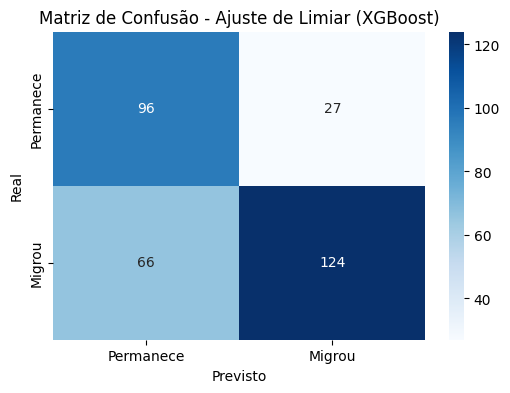

In [109]:
# Ajuste de limiar com base no conjunto de treinamento
best_model_m3.fit(X_train_m3, y_train_m3)  # Treine o modelo primeiro!

y_prob_train = best_model_m3.predict_proba(X_train_m3)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_train_m3, y_prob_train)

# Encontrar o melhor limiar com base no F1 Score
best_threshold = 0.5
best_f1 = 0
for threshold in thresholds:
    y_pred_adjusted = (y_prob_train >= threshold).astype(int)
    f1 = f1_score(y_train_m3, y_pred_adjusted)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Melhor limiar: {best_threshold} com F1 Score: {best_f1}")

# Matriz de Confusão com limiar ajustado no conjunto de teste
y_prob_test = best_model_m3.predict_proba(X_test_m3)[:, 1]
y_pred_adjusted = (y_prob_test >= best_threshold).astype(int)
cm_adjusted = confusion_matrix(y_test_m3, y_pred_adjusted)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_adjusted, annot=True, fmt='d', cmap='Blues', xticklabels=['Permanece', 'Migrou'], yticklabels=['Permanece', 'Migrou'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title(f'Matriz de Confusão - Ajuste de Limiar ({best_model_name})')
plt.show()

In [110]:
print("ROC AUC: ", roc_auc_score(y_test_m3, y_prob_test))
print("Precision: ", precision_score(y_test_m3, y_pred_adjusted))
print("Accuracy: ", accuracy_score(y_test_m3, y_pred_adjusted))
print("Recall: ", recall_score(y_test_m3, y_pred_adjusted))
print("F1 Score: ", f1_score(y_test_m3, y_pred_adjusted))
print("Houve perda da área abaixo da curva ROC e no Recall. Nas outras métricas, houve melhora")

ROC AUC:  0.7828840393667094
Precision:  0.8211920529801324
Accuracy:  0.7028753993610224
Recall:  0.6526315789473685
F1 Score:  0.7272727272727273
Houve perda da área abaixo da curva ROC e no Recall. Nas outras métricas, houve melhora


In [111]:
# Fazendo previsões de probabilidade no conjunto de teste
y_prob_best = best_model_m3.predict_proba(X_test_m3)[:, 1]

# Ajustando as previsões com o novo limiar
y_pred_adjusted = (y_prob_best >= best_threshold).astype(int)

# Imprimindo o relatório de classificação com o limiar ajustado
print(classification_report(y_test_m3, y_pred_adjusted))

              precision    recall  f1-score   support

           0       0.59      0.78      0.67       123
           1       0.82      0.65      0.73       190

    accuracy                           0.70       313
   macro avg       0.71      0.72      0.70       313
weighted avg       0.73      0.70      0.71       313



In [168]:
explainer = shap.Explainer(best_model_m3.predict, 
                           X_test_m3)

shap_values = explainer(X_test_m3)

ValueError: Feature shape mismatch, expected: 27, got 26

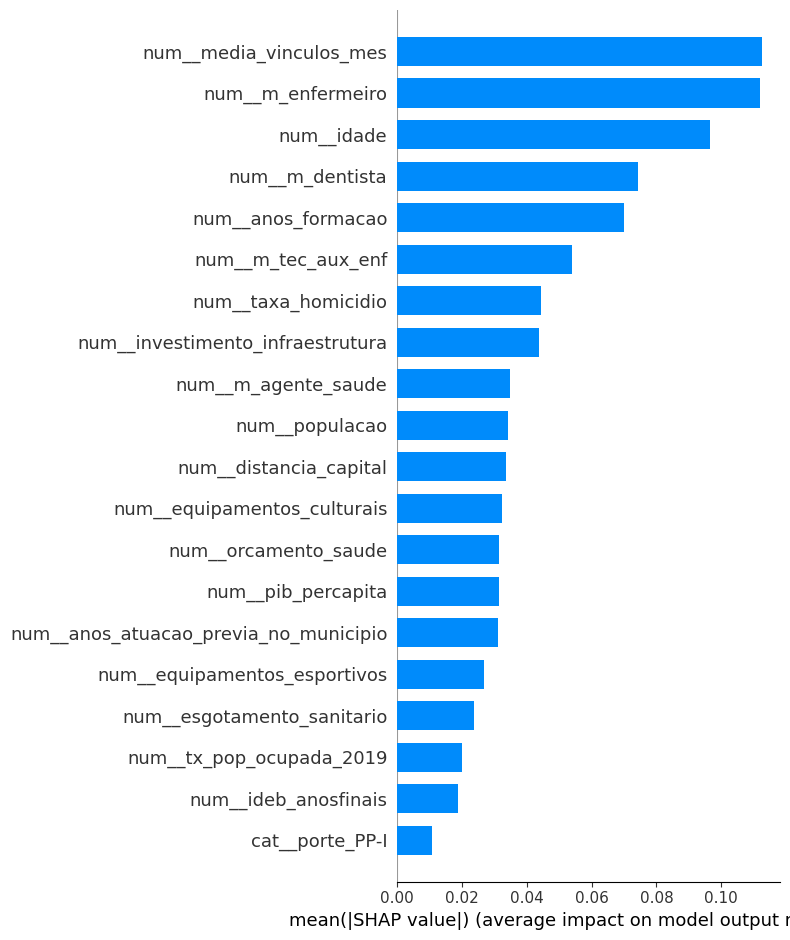

In [113]:
# Recuperando o nome das variáveis
feature_names = preprocessor_m3.get_feature_names_out()

#Gerando o gráfico
shap.summary_plot(shap_values, features= X_test_m3, 
                  feature_names= feature_names, 
                  plot_type="bar")

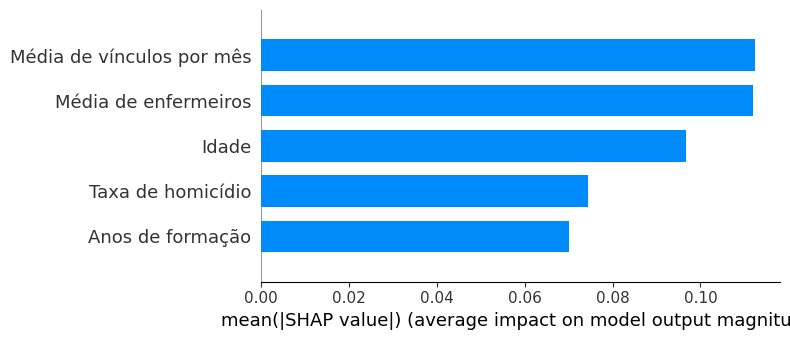

In [114]:
nomes_m3 = ['Idade', 'Anos de formação', 'Média de enfermeiros', 'Média de vínculos por mês', 'Média de cirurgiões-dentistas',
'População', 'Média de enfermeiros', 'Taxa de homicídio', 'Orçamento Saúde', 'Teste', 'Teste',
'Teste', 'Teste', 'Teste', 'Teste', 'Teste', 'Teste', 'Teste', 'Teste', 'Teste', 'Teste']

shap.summary_plot(shap_values, features= X_test_m3, 
                  feature_names= nomes_m3, 
                  plot_type="bar",
                 max_display=5)

### Modelo 4

In [152]:
results_m4, models_m4 = treinando_avaliando_optuna(X_train_m4, y_train_m4, X_test_m4, y_test_m4)
results_m4_df = pd.DataFrame(results_m4)
print(results_m4_df.sort_values(by='ROC AUC', ascending=False))

[I 2025-03-03 20:35:24,453] A new study created in memory with name: no-name-2b60872f-64f0-4159-8048-34c970758a7c
C:\Users\Lapei_Cigets\AppData\Local\Temp\ipykernel_26296\4280298713.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.01, 10)
[I 2025-03-03 20:35:24,462] Trial 0 finished with value: 0.8609366343490304 and parameters: {'C': 0.05826351733192066}. Best is trial 0 with value: 0.8609366343490304.
C:\Users\Lapei_Cigets\AppData\Local\Temp\ipykernel_26296\4280298713.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.01, 10)
[I 2025-03-03 20:35:24,478] Trial 1 finished with value: 0.863504155

Treinando modelo com Optuna: Logistic Regression
Melhores parâmetros para Logistic Regression: {'C': 3.369318630506155}

Treinando modelo com Optuna: Decision Tree


[I 2025-03-03 20:35:24,660] Trial 4 finished with value: 0.9347524238227147 and parameters: {'max_depth': 7}. Best is trial 1 with value: 0.9347524238227147.
[I 2025-03-03 20:35:24,688] Trial 5 finished with value: 0.9748320637119114 and parameters: {'max_depth': 10}. Best is trial 5 with value: 0.9748320637119114.
[I 2025-03-03 20:35:24,709] Trial 6 finished with value: 0.9657245498614958 and parameters: {'max_depth': 9}. Best is trial 5 with value: 0.9748320637119114.
[I 2025-03-03 20:35:24,738] Trial 7 finished with value: 0.9657245498614958 and parameters: {'max_depth': 9}. Best is trial 5 with value: 0.9748320637119114.
[I 2025-03-03 20:35:24,753] Trial 8 finished with value: 0.8776471606648201 and parameters: {'max_depth': 4}. Best is trial 5 with value: 0.9748320637119114.
[I 2025-03-03 20:35:24,773] Trial 9 finished with value: 0.9347524238227147 and parameters: {'max_depth': 7}. Best is trial 5 with value: 0.9748320637119114.
[I 2025-03-03 20:35:24,789] A new study created in 

Melhores parâmetros para Decision Tree: {'max_depth': 10}

Treinando modelo com Optuna: Random Forest


[I 2025-03-03 20:35:25,987] Trial 0 finished with value: 0.983215027700831 and parameters: {'n_estimators': 400, 'max_depth': 8, 'min_samples_split': 3}. Best is trial 0 with value: 0.983215027700831.
[I 2025-03-03 20:35:26,287] Trial 1 finished with value: 0.9917590027700831 and parameters: {'n_estimators': 100, 'max_depth': 9, 'min_samples_split': 2}. Best is trial 1 with value: 0.9917590027700831.
[I 2025-03-03 20:35:27,221] Trial 2 finished with value: 0.9139577562326869 and parameters: {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 8}. Best is trial 1 with value: 0.9917590027700831.
[I 2025-03-03 20:35:27,887] Trial 3 finished with value: 0.9550986842105262 and parameters: {'n_estimators': 300, 'max_depth': 6, 'min_samples_split': 6}. Best is trial 1 with value: 0.9917590027700831.
[I 2025-03-03 20:35:29,239] Trial 4 finished with value: 0.983483379501385 and parameters: {'n_estimators': 500, 'max_depth': 8, 'min_samples_split': 3}. Best is trial 1 with value: 0.991759

Melhores parâmetros para Random Forest: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 4}

Treinando modelo com Optuna: XGBoost


c:\Users\Lapei_Cigets\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:35:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-03-03 20:35:34,536] Trial 0 finished with value: 0.9999688365650969 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.03583951437010995, 'subsample': 0.7690168649143314, 'colsample_bytree': 0.7532015307900954, 'gamma': 0.33104423936343297}. Best is trial 0 with value: 0.9999688365650969.
c:\Users\Lapei_Cigets\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:35:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-03-03 20:35:35,018] 

Melhores parâmetros para XGBoost: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.04073585391451004, 'subsample': 0.9529811588526091, 'colsample_bytree': 0.8066140155909288, 'gamma': 0.29711458401617324}

Treinando modelo com Optuna: LightGBM
[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4163
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-03-03 20:35:37,935] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 400, 'learning_rate': 0.04355417571957383, 'num_leaves': 34, 'min_child_samples': 29}. Best is trial 0 with value: 1.0.


[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4163
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-03-03 20:35:38,432] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 400, 'learning_rate': 0.03388388447671018, 'num_leaves': 40, 'min_child_samples': 17}. Best is trial 0 with value: 1.0.


[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4163
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-03-03 20:35:38,688] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 400, 'learning_rate': 0.06176648680995345, 'num_leaves': 24, 'min_child_samples': 26}. Best is trial 0 with value: 1.0.
[I 2025-03-03 20:35:38,794] Trial 3 finished with value: 1.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.09025012962976078, 'num_leaves': 36, 'min_child_samples': 10}. Best is trial 0 with value: 1.0.


[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4163
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4163
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-03-03 20:35:39,073] Trial 4 finished with value: 1.0 and parameters: {'n_estimators': 400, 'learning_rate': 0.038541435969143216, 'num_leaves': 26, 'min_child_samples': 26}. Best is trial 0 with value: 1.0.
[I 2025-03-03 20:35:39,225] Trial 5 finished with value: 1.0 and parameters: {'n_estimators': 200, 'learning_rate': 0.05137552043385071, 'num_leaves': 28, 'min_child_samples': 18}. Best is trial 0 with value: 1.0.


[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4163
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4163
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-03-03 20:35:39,684] Trial 6 finished with value: 1.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.05245351924653788, 'num_leaves': 31, 'min_child_samples': 26}. Best is trial 0 with value: 1.0.
[I 2025-03-03 20:35:39,796] Trial 7 finished with value: 1.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.0707292918177643, 'num_leaves': 38, 'min_child_samples': 18}. Best is trial 0 with value: 1.0.


[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4163
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4163
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-03-03 20:35:40,202] Trial 8 finished with value: 0.9994494459833795 and parameters: {'n_estimators': 500, 'learning_rate': 0.010838861778564624, 'num_leaves': 30, 'min_child_samples': 15}. Best is trial 0 with value: 1.0.


[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4163
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-03-03 20:35:40,698] Trial 9 finished with value: 1.0 and parameters: {'n_estimators': 400, 'learning_rate': 0.08422168419159795, 'num_leaves': 39, 'min_child_samples': 10}. Best is trial 0 with value: 1.0.


[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4163
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Melhores parâmetros para LightGBM: {'n_estimators': 400, 'learning_rate': 0.04355417571957383, 'num_leaves': 34, 'min_child_samples': 29}

                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
2        Random Forest  0.789137   0.860465  0.778947  0.817680  0.860548
3              XGBoost  0.792332   0.841530  0.810526  0.825737  0.845828
0  Logistic Regression  0.785942   0.872727  0.757895  0.811268  0.844202
4             LightGBM  0.750799   0.804348  0.778947  0.791444  0.835558
1        Decision Tree  0.702875   0.790419  0.694737  0.

In [153]:
best_model_name = results_m4_df.sort_values(by='ROC AUC', 
                                         ascending=False).iloc[0]['Model']

best_model_m4 = models_m4[best_model_name]


Melhor limiar: 0.51 com F1 Score: 1.0


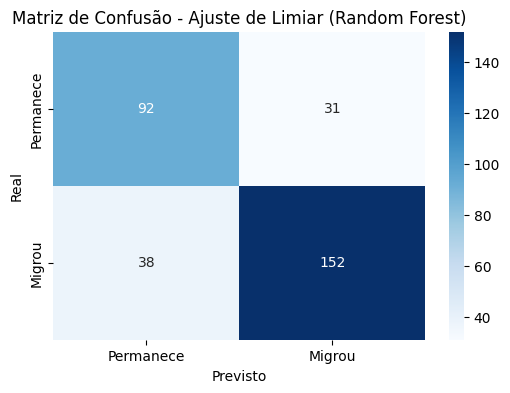

In [154]:
# Ajuste de limiar com base no conjunto de treinamento
best_model_m4.fit(X_train_m4, y_train_m4)  # Treine o modelo primeiro!

y_prob_train = best_model_m4.predict_proba(X_train_m4)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_train_m4, y_prob_train)

# Encontrar o melhor limiar com base no F1 Score
best_threshold = 0.5
best_f1 = 0
for threshold in thresholds:
    y_pred_adjusted = (y_prob_train >= threshold).astype(int)
    f1 = f1_score(y_train_m4, y_pred_adjusted)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Melhor limiar: {best_threshold} com F1 Score: {best_f1}")

# Matriz de Confusão com limiar ajustado no conjunto de teste
y_prob_test = best_model_m4.predict_proba(X_test_m4)[:, 1]
y_pred_adjusted = (y_prob_test >= best_threshold).astype(int)
cm_adjusted = confusion_matrix(y_test_m3, y_pred_adjusted)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_adjusted, annot=True, fmt='d', cmap='Blues', xticklabels=['Permanece', 'Migrou'], yticklabels=['Permanece', 'Migrou'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title(f'Matriz de Confusão - Ajuste de Limiar ({best_model_name})')
plt.show()

In [37]:
print("ROC AUC: ", roc_auc_score(y_test_m4, y_prob_test))
print("Precision: ", precision_score(y_test_m4, y_pred_adjusted))
print("Accuracy: ", accuracy_score(y_test_m4, y_pred_adjusted))
print("Recall: ", recall_score(y_test_m4, y_pred_adjusted))
print("F1 Score: ", f1_score(y_test_m4, y_pred_adjusted))
print("Houve perda da área abaixo da curva ROC e no Recall. Nas outras métricas, houve melhora")

ROC AUC:  0.8522892597347027
Precision:  0.8963414634146342
Accuracy:  0.8083067092651757
Recall:  0.7736842105263158
F1 Score:  0.8305084745762712
Houve perda da área abaixo da curva ROC e no Recall. Nas outras métricas, houve melhora


In [120]:
# Fazendo previsões de probabilidade no conjunto de teste
y_prob_best = best_model_m4.predict_proba(X_test_m4)[:, 1]

# Ajustando as previsões com o novo limiar
y_pred_adjusted = (y_prob_best >= best_threshold).astype(int)

# Imprimindo o relatório de classificação com o limiar ajustado
print(classification_report(y_test_m4, y_pred_adjusted))

              precision    recall  f1-score   support

           0       0.69      0.79      0.73       123
           1       0.85      0.77      0.81       190

    accuracy                           0.78       313
   macro avg       0.77      0.78      0.77       313
weighted avg       0.79      0.78      0.78       313



Treinando Logistic Regression...
Logistic Regression - AUC: 0.8448, Melhor Threshold: 0.3218
Treinando Decision Tree...
Decision Tree - AUC: 0.6367, Melhor Threshold: 0.0000
Treinando Random Forest...
Random Forest - AUC: 0.8440, Melhor Threshold: 0.5700
Treinando XGBoost...
XGBoost - AUC: 0.8315, Melhor Threshold: 0.5170
Treinando LightGBM...
[LightGBM] [Info] Number of positive: 760, number of negative: 760
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4163
[LightGBM] [Info] Number of data points in the train set: 1520, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\Lapei_Cigets\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:36:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


LightGBM - AUC: 0.8417, Melhor Threshold: 0.6496


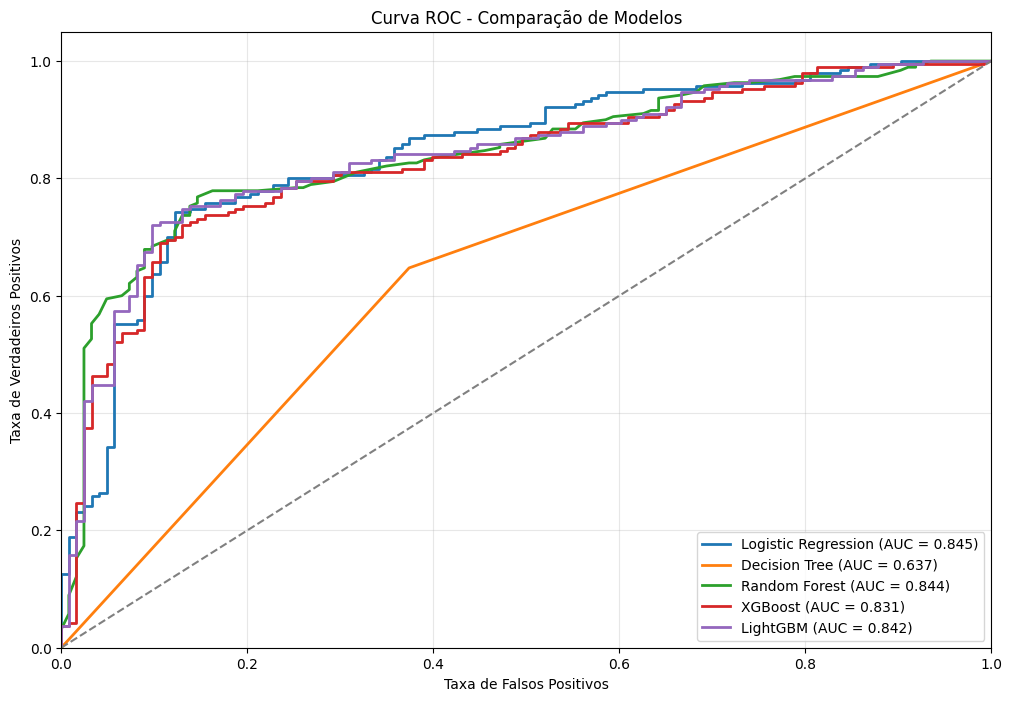

In [155]:
# Dicionário para armazenar os resultados
best_models = {}
best_thresholds = {}
y_probs = {}

# Treinando cada modelo e calculando as métricas
for name, model in models.items():
    print(f"Treinando {name}...")
    model.fit(X_train_m4, y_train_m4)
    y_prob = model.predict_proba(X_test_m4)[:, 1]
    y_probs[name] = y_prob
    
    # Encontrar o melhor threshold usando precision-recall
    precision, recall, thresholds = precision_recall_curve(y_test_m4, y_prob)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    best_threshold = thresholds[ix] if ix < len(thresholds) else 0.5
    
    best_models[name] = model
    best_thresholds[name] = best_threshold
    
    print(f"{name} - AUC: {roc_auc_score(y_test_m4, y_prob):.4f}, Melhor Threshold: {best_threshold:.4f}")

# Plotando a curva ROC para todos os modelos
plt.figure(figsize=(12, 8))

for name, y_prob in y_probs.items():
    fpr, tpr, _ = roc_curve(y_test_m4, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Comparação de Modelos')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [156]:
explainer = shap.Explainer(best_model_m4.predict, 
                           X_test_m4)

shap_values = explainer(X_test_m4)

PermutationExplainer explainer: 314it [01:17,  3.51it/s]                         


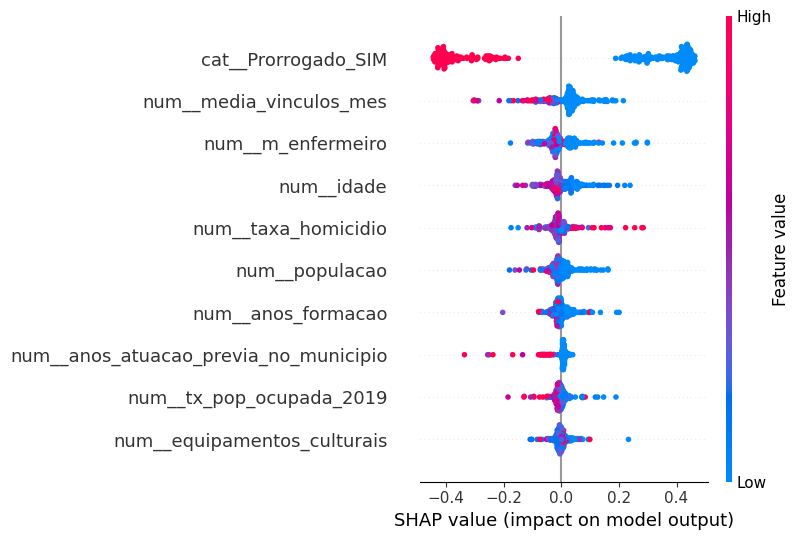

In [164]:
# Recuperando o nome das variáveis
feature_names = preprocessor_m4.get_feature_names_out()

shap.summary_plot(shap_values, 
                  X_test_m4, 
                  feature_names=feature_names,
                  max_display = 10)


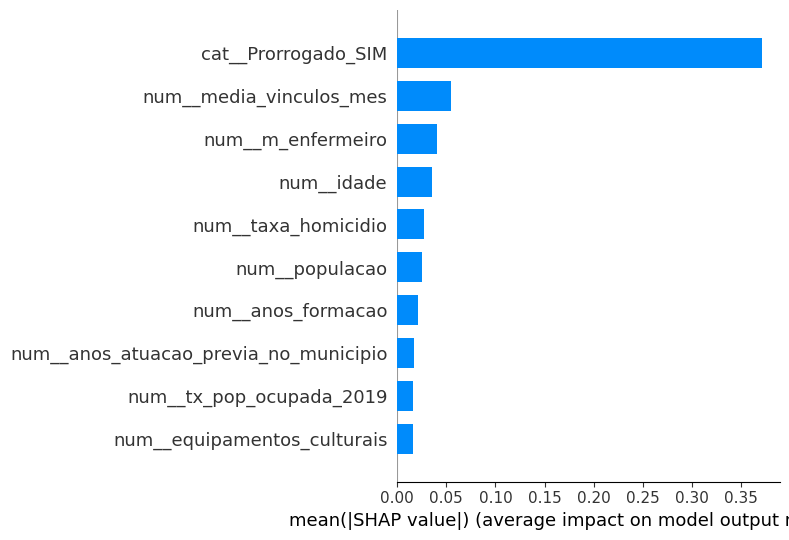

In [165]:

#Gerando o gráfico
shap.summary_plot(shap_values, features= X_test_m4, 
                  feature_names= feature_names, 
                  plot_type="bar", 
                  max_display = 10)

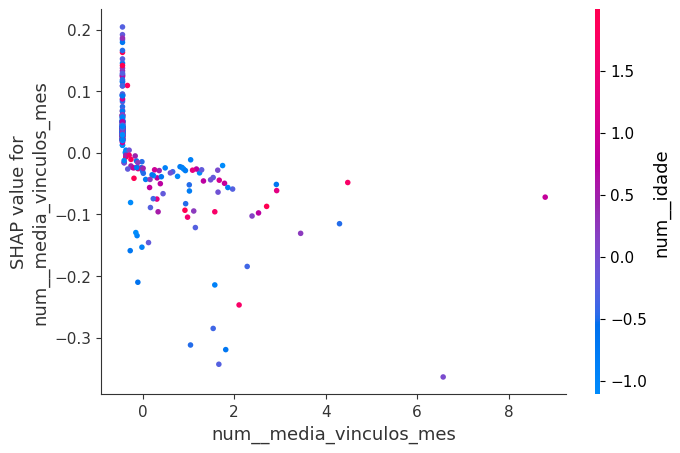

In [133]:
if 'num__media_vinculos_mes' in feature_names:
    shap.dependence_plot('num__media_vinculos_mes', shap_values.values, X_test_m4, feature_names=feature_names, 
                         interaction_index='num__idade')
